# Harris County Home Price Estimations

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from Load_to_DataFrame import load_data_frame


In [2]:
df = load_data_frame()

In [3]:
df.head()

,acct,bld_num,date_erected,im_sq_ft,land_ar,perimeter,dpr_val,bedrooms,full_bath,half_bath,...,foundation_repaired,cracked_slab,lat,long,land_val,bld_val,assessed_val,tot_appr_val,tot_mkt_val,assessed_per_sqft
0,20720000014,1,2019,2534,5564,452,483261,3.0,3.0,1.0,...,0,0,-95.356534,29.743903,253352.0,451951.0,705303.0,705303.0,705303.0,278.335833
1,21440000001,1,2004,2537,5000,314,307658,3.0,2.0,1.0,...,0,0,-95.358428,29.740005,200000.0,307658.0,510178.0,311246.0,510178.0,201.094994
2,21480000002,1,1917,1496,5000,186,9621,3.0,1.0,0.0,...,0,0,-95.361765,29.742185,200000.0,9486.0,209586.0,209586.0,209586.0,140.097594
3,21650000007,1,2015,3387,5000,578,587261,3.0,3.0,1.0,...,0,0,-95.361889,29.741158,200000.0,523919.0,723919.0,723919.0,723919.0,213.734573
4,21650000011,1,2003,1508,6250,210,172034,3.0,2.0,0.0,...,0,0,-95.361493,29.741294,225000.0,172034.0,397034.0,388778.0,397034.0,263.285146


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121077 entries, 0 to 1121076
Data columns (total 37 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   acct                   1121077 non-null  int64  
 1   bld_num                1121077 non-null  int64  
 2   date_erected           1121077 non-null  int64  
 3   im_sq_ft               1121077 non-null  int64  
 4   land_ar                1121077 non-null  int64  
 5   perimeter              1121077 non-null  int64  
 6   dpr_val                1121077 non-null  object 
 7   bedrooms               1121077 non-null  float64
 8   full_bath              1121077 non-null  float64
 9   half_bath              1121077 non-null  float64
 10  total_rooms            1121077 non-null  float64
 11  dscr_good              1121077 non-null  int64  
 12  dscr_average           1121077 non-null  int64  
 13  dscr_low               1121077 non-null  int64  
 14  dscr_very_low     

In [5]:
df.columns

Index(['acct', 'bld_num', 'date_erected', 'im_sq_ft', 'land_ar', 'perimeter',
       'dpr_val', 'bedrooms', 'full_bath', 'half_bath', 'total_rooms',
       'dscr_good', 'dscr_average', 'dscr_low', 'dscr_very_low',
       'dscr_excellent', 'dscr_superior', 'dscr_poor', 'frame_detached_garage',
       'gunite_pool', 'solar_panel', 'pool_heater', 'brick_garage',
       'canopy_residential', 'frame_abov', 'frame_shed', 'carport_residential',
       'foundation_repaired', 'cracked_slab', 'lat', 'long', 'land_val',
       'bld_val', 'assessed_val', 'tot_appr_val', 'tot_mkt_val',
       'assessed_per_sqft'],
      dtype='object')

# Reduce data set to manageable size
The current data set is over 1.1M rows. This will take days to train a model on a regular computer. 

The help reduce the dataset I will start by removing all homes where the im_sq_ft is less than 50, since it is not really livable when there are not even 50 square feet of space. 

Next I will use the IQR to assess the market value and remove outliers so the data will not be as skewed.

In [6]:
y_market = df['tot_mkt_val']
y_assessed = df['assessed_val']
y_bld_val = df['bld_val']
y_per_sqft = df['assessed_per_sqft']


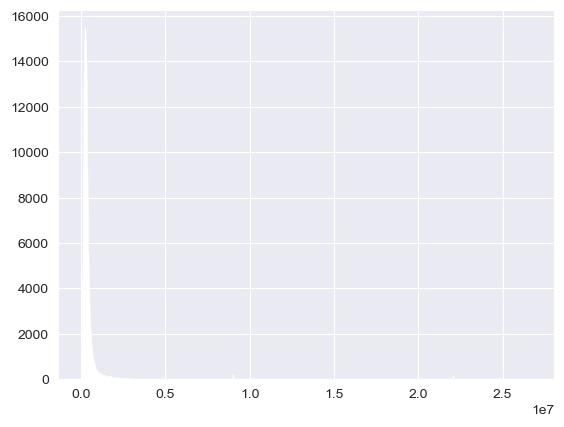

In [7]:
plt.hist(y_market, bins='auto')
plt.show()

In [8]:
X = df[['date_erected', 'im_sq_ft', 'land_ar', 'perimeter',
     'dpr_val', 'bedrooms', 'full_bath', 'half_bath', 'total_rooms',
     'dscr_good', 'dscr_average', 'dscr_low', 'dscr_very_low',
     'dscr_excellent', 'dscr_superior', 'dscr_poor', 'frame_detached_garage',
     'gunite_pool', 'solar_panel', 'pool_heater', 'brick_garage',
     'canopy_residential', 'frame_abov', 'frame_shed', 'carport_residential',
     'foundation_repaired', 'cracked_slab', 'lat', 'long']]
y_market = df['tot_mkt_val']
y_assessed = df['assessed_val']
y_bld_val = df['bld_val']
y_per_sqft = df['assessed_per_sqft']

In [9]:
# IQR
Q1 = df['assessed_val'].quantile(0.25)
Q3 = df['assessed_val'].quantile(0.75)
IQR = Q3 - Q1

lower_iqr = (Q1 - 1.5 * IQR)
upper_iqr = (Q3 + 2 * IQR)
print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

# Filter data_df to values between Lower IQR and Upper IQR
reduced_df = df[df['assessed_val'] <= 2000000]

Lower IQR: -43376.0 | Upper IQR: 739327.0


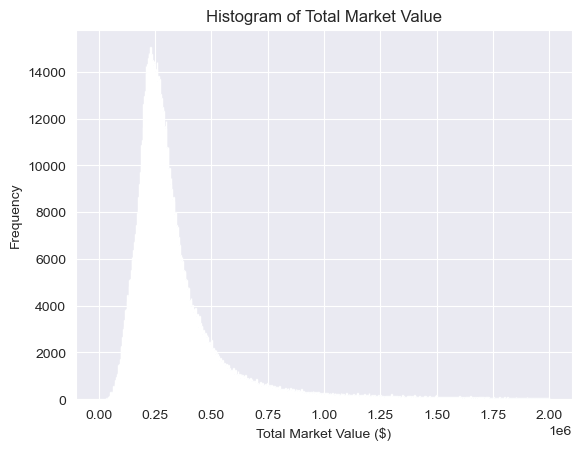

In [10]:
plt.hist(reduced_df['tot_mkt_val'], bins='auto')
plt.xlabel('Total Market Value ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Total Market Value')
plt.show()

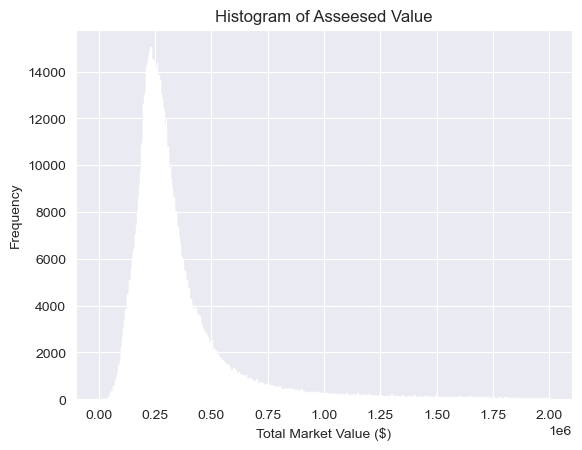

In [13]:
plt.hist(reduced_df['assessed_val'], bins='auto')
plt.xlabel('Total Market Value ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Assessed Value')
plt.show()

In [ ]:
all_df[x_categorical].head()

In [ ]:
# initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first')

#Fit and transform the categorical columns
encoded = encoder.fit_transform(all_df[x_categorical])

df_results = pd.DataFrame.sparse.from_spmatrix(encoded)
df_results.columns = encoder.get_feature_names_out(x_categorical)
df_results.shape

In [ ]:
df_results.info()

In [ ]:
# Free up memory
building_data = None
fix_pt = None
fixtures = None


In [ ]:
# Reset index of both dataframes
all_df.reset_index(drop=True, inplace=True)
df_results.reset_index(drop=True, inplace=True)

# Merge the encoded data and continuous data together
encoded_features = pd.concat([all_df[x_continuous], df_results], join='inner', axis=1)

In [ ]:
encoded_features.shape

In [ ]:
# sns.histplot(data=all_df, x="assessed_val")

In [ ]:
# sns.histplot(data=all_df, x="assessed_val", log_scale=True)

In [ ]:
# sns.pairplot(data=all_df, vars=['assessed_val', 'date_erected', 'im_sq_ft', 'school_dist', 'Neighborhood_Code'])

In [ ]:
# sns.pairplot(data=all_df, vars=['assessed_val', 'land_ar', 'RMB', 'RMF', 'RMH', 'STY'])

In [ ]:
print(f"Encoded features{encoded_features.shape} | All Data{all_df.shape} | Results {df_results.shape} | y {y.shape} ")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(encoded_features, y, test_size=0.4, random_state=42)

In [ ]:
model = ExtraTreesRegressor(n_estimators=100, random_state=42)

In [ ]:
model_fit = model.fit(x_train, y_train)

In [ ]:
cross_val_score(model_fit, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1).mean()

In [ ]:
y_pred = model.predict(x_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

In [ ]:
param_grid = {
    'n_estimators': [100, 250, 500],
    'min_samples_leaf': [5, 15, 25],
    'max_features': [10, 20, 30],
    'criterion': ['gini', 'entropy']
}

In [ ]:
etc2 = GridSearchCV(model_fit, param_grid, cv=3, n_jobs=-1)

In [ ]:
etc2.fit(x_train, y_train)

In [ ]:
etc2.best_params_

In [ ]:
etc2.best_score_